In [17]:
using LinearAlgebra, Kronecker, SpecialFunctions

In [30]:
model.gamma_sample[1][1][1][50]

100-element Vector{Vector{Float64}}:
 [6.9528332294141e-310]
 [1.3466435926944e-311]
 [1.3466435927814e-311]
 [1.346623827958e-311]
 [1.3466435927814e-311]
 [1.3466435927893e-311]
 [1.3466435927893e-311]
 [1.3466582743966e-311]
 [1.346634643221e-311]
 [6.95283321982686e-310]
 [6.95283676768934e-310]
 [6.95283321982686e-310]
 [0.0]
 ⋮
 [1.346643588663e-311]
 [1.347299373694e-311]
 [7.13115449964e-313]
 [0.0]
 [2.5e-323]
 [0.0]
 [1.5e-323]
 [7.13115449964e-313]
 [7.10234771575e-313]
 [6.9528332294141e-310]
 [1.347307260705e-311]
 [6.4e-323]

In [ ]:
function update_normal_variational_distribution2(
    model       :: TDCModel;
    init_step   :: T=1e-3,
    step_iterator=get_robbins_monroe_iterator(init_step, 20),
    # step_iterator_factory=get_robbins_monroe_iterator,
    use_iter    :: Bool=false,
    tol         :: T=1e-6,
    maxiter     :: Int=100000,
    verbose     :: Bool=true
) where T <: AbstractFloat
    obs = model.obs
    Y, D = Array{T, 3}(obs.Y), Vector{Matrix{T}}(obs.D)
    Z_sample, gamma_sample, omega_sample, tau_sample = model.Z_sample, model.gamma_sample, model.omega_sample, model.tau_sample
    mu_star_old, V_star_old = model.mu_gamma_star, model.V_gamma_star
    N, J, L, O = size(Y, 1), size(Y, 3), size(D[1], 1), size(obs.Y, 2)
    M = model.M
    # Fully update parameters of each γ using noisy gradients before moving to update parameters of next γ
    if !model.enable_parallel
        @inbounds for k in 1:K
            for t in 1:O
                for z in 0:1
                    mu_star_old_j = mu_star_old[j]
                    V_star_old_j = V_star_old[j]
                    # Perform gradient descent update of mu_j and V_j
                    len_gamma = length(gamma_sample[j][1])
                    # Assign storage for gradient terms
                    # Memory assigned from preallocated storage
                    # Memory has to be strided (equal stride between memory addresses) to work with BLAS and LAPACK 
                    # (important for vectorized matricies to be strided if we want to use them for linear algebra)
                    # Matricies are stored column major in Julia, so memory is assigned by column left to right
                    grad_mu_L = view(model.storage_L, 1:len_gamma)
                    grad_C_L = view(model.storage_LL2, 1:len_gamma, 1:len_gamma)
                    vech_grad_C_L = view(grad_C_L, [len_gamma * (j - 1) + i for j in 1:len_gamma for i in j:len_gamma]) # Uses same memory as grad_C_L
                    grad_mu_log_q = view(model.storage_L2, 1:len_gamma)
                    vec_grad_V_log_q = view(model.storage_LL3, 1:len_gamma^2)
                    grad_V_log_q = reshape(vec_grad_V_log_q, len_gamma, len_gamma) # Uses same memory as vec_grad_V_log_q
                    # Assign storage for calculating intermediate terms for gradient
                    Vinv_star_old_j = view(model.storage_LL, 1:len_gamma, 1:len_gamma)
                    beta_minus_mu = view(model.storage_L3, 1:len_gamma)
                    L_beta_minus_mu = view(model.storage_L4, 1:len_gamma)
                    C_star_old_j = view(model.storage_C, 1:len_gamma, 1:len_gamma)
                    vech_C_star_old_j = view(C_star_old_j, [len_gamma * (j - 1) + i for j in 1:len_gamma for i in j:len_gamma]) # Uses same memory as C_star_old_j
                    fill!(C_star_old_j, 0)
                    storage_kron_prod = view(model.storage_L2L2, 1:len_gamma^2, 1:len_gamma^2)
                    storage_len_gamma_sqr = view(model.storage_Lsqr, 1:len_gamma^2)
                    storage_len_gamma_sqr2 = view(model.storage_Lsqr2, 1:len_gamma^2)
                    storage_gradC = view(model.storage_gradC, 1:Int(len_gamma * (len_gamma + 1) / 2))
                    # Generate commutation and duplication matrix
                    comm_j = view(model.storage_comm, 1:len_gamma^2, 1:len_gamma^2)
                    dup_j = view(model.storage_dup, 1:len_gamma^2, 1:Int(len_gamma * (len_gamma + 1) / 2))
                    get_comm!(comm_j, len_gamma)
                    get_dup!(dup_j, len_gamma)
                    # Assign len_gamma by len_gamma identity matrix
                    I_j = view(model.I_LL, 1:len_gamma, 1:len_gamma)
                    # # Get step size iterator
                    # step_iterator = step_iterator_factory(init_step)
                    for iter in 1:maxiter
                        # Sample β from variational distribution
                        sample_β(model, idx_question=j)
                        fill!(grad_mu_L, 0)
                        fill!(grad_C_L, 0)
                        # Copy V* into storage
                        copy!(Vinv_star_old_j, V_star_old_j)
                        # Perform cholesky decomposition on V*
                        # After this step, the lower triangle of Vinv_star_old_j will contain the lower triangular cholesky factor of V*
                        LAPACK.potrf!('L', Vinv_star_old_j)
                        # Calculate log|V_j| from diagonal of cholesky decomposition
                        logdet_V_j = 0
                        for b in 1:len_gamma
                            logdet_V_j += 2 * log(Vinv_star_old_j[b, b])
                        end
                        # Copy lower triangular cholesky factor into preallocated storage
                        for k in 1:len_gamma
                            for l in 1:k
                                C_star_old_j[k, l] = Vinv_star_old_j[k, l]
                            end
                        end
                        # Perform in place matrix inverse on positive definite V* matrix to get V* inverse
                        LAPACK.potri!('L', Vinv_star_old_j)
                        LinearAlgebra.copytri!(Vinv_star_old_j, 'L')
                        ELBO = 0
                        # Calculate the gradient estimate of the m-th sample
                        for m in 1:M
                            beta_jm = beta_sample[j][m]
                            fill!(grad_mu_log_q, 0)
                            # grad_mu_log_q = Vinv_star * β_jm
                            BLAS.gemv!('N', T(1), Vinv_star_old_j, beta_jm, T(1), grad_mu_log_q)
                            # grad_mu_log_q = Vinv_star_j * β_jm - Vinv_star_j * mu_star_j
                            BLAS.gemv!('N', T(-1), Vinv_star_old_j, mu_star_old_j, T(1), grad_mu_log_q)
                            # grad_V_log_q = -1/2(Vinv_star_j - Vinv_star_j * (β_jm - mu_star_j) * (β_jm - mu_star_j)^T * Vinv_star_j)
                            copy!(grad_V_log_q, Vinv_star_old_j)
                            BLAS.gemm!('N', 'T', T(1 / 2), grad_mu_log_q, grad_mu_log_q, T(-1 / 2), grad_V_log_q)
                            # storage_kron_prod = I ⊗ C_j
                            collect!(storage_kron_prod, kronecker(I_j, C_star_old_j))
                            # storage_len_gamma_sqr = (I ⊗ C_j)'vec(grad_V_log_q)
                            BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_gamma_sqr, 0))
                            # storage_kron_prod = C_j ⊗ I
                            collect!(storage_kron_prod, kronecker(C_star_old_j, I_j))
                            # storage_len_gamma_sqr2 = (C_j ⊗ I)'vec(grad_V_log_q)
                            BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_gamma_sqr2, 0))
                            # storage_len_gamma_sqr2 = ((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                            BLAS.gemv!('T', T(1), comm_j, storage_len_gamma_sqr, T(1), storage_len_gamma_sqr2)
                            # storage_gradC = D'((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                            BLAS.gemv!('T', T(1), dup_j, storage_len_gamma_sqr2, T(1), fill!(storage_gradC, 0))
                            # Calculate log(p(Y, β_(j)))
                            log_prob_Ybeta = 0
                            for i in 1:N
                                for t in 1:O
                                    fill!(model.storage_L3, 0)
                                    BLAS.gemv!('N', (2 * Y[i, t, j] - 1), D[j], beta_jm, T(1), model.storage_L3)
                                    log_prob_Ybeta += dot(Z_sample[i][t][m], log.(sigmoid.(model.storage_L3)))
                                end
                            end
                            beta_minus_mu .= beta_jm
                            beta_minus_mu .-= model.mu_beta_prior[j]
                            mul!(L_beta_minus_mu, model.L_beta_prior[j], beta_minus_mu)
                            log_prob_Ybeta -= 1/2 * dot(L_beta_minus_mu, L_beta_minus_mu)
                            beta_minus_mu .= beta_jm
                            beta_minus_mu .-= mu_star_old_j
                            log_q = -len_gamma / 2 * log(2 * pi) - 1 / 2 * logdet_V_j - 1 / 2 * dot(beta_minus_mu, grad_mu_log_q)
                            # Update average gradient
                            grad_mu_L .= (m - 1) / m .* grad_mu_L + 1 / m .* grad_mu_log_q .* (log_prob_Ybeta - log_q)
                            vech_grad_C_L .= (m - 1) / m .* vech_grad_C_L + 1 / m .* storage_gradC .* (log_prob_Ybeta - log_q)
                            # Update ELBO estimator
                            ELBO = (m - 1) / m * ELBO + 1 / m * (log_prob_Ybeta - log_q)
                        end
                        # Print ELBO, parameter and gradient if verbose
                        # if verbose
                        #     println("ELBO: $ELBO")
                        #     println("mu*_$j: mu_star_old_j")
                        #     println("gradient mu: $grad_mu_L")
                        #     println("C*_$j: C_star_old_j")
                        #     println("gradient C: $grad_C_L")
                        # end
                        # Update mu and C with one step
                        step = init_step
                        if use_iter
                            step = step_iterator()
                        end
                        mu_star_old_j .+= step .* grad_mu_L ./ norm(grad_mu_L)
                        vech_C_star_old_j .+= step .* vech_grad_C_L ./ norm(vech_grad_C_L)
                        # Set V_star_old_j = C * C'
                        BLAS.gemm!('N', 'T', T(1), C_star_old_j, C_star_old_j, T(1), fill!(V_star_old_j, 0))
                    end
                end
            end
        end
    else
        Threads.@threads for j in 1:J
            # Get thread id
            tid = Threads.threadid()
            # Perform gradient descent update of mu_j and V_j
            len_gamma = length(beta_sample[j][1])
            # Assign storage for gradient terms
            # Memory assigned from preallocated storage
            # Memory has to be strided (equal stride between memory addresses) to work with BLAS and LAPACK 
            # (important for vectorized matricies to be strided if we want to use them for linear algebra)
            # Matricies are stored column major in Julia, so memory is assigned by column left to right
            grad_mu_L = view(model.storage_L_par[tid], 1:len_gamma)
            grad_C_L = view(model.storage_LL2_par[tid], 1:len_gamma, 1:len_gamma)
            vech_grad_C_L = view(grad_C_L, [len_gamma * (j - 1) + i for j in 1:len_gamma for i in j:len_gamma]) # Uses same memory as grad_C_L
            grad_mu_log_q = view(model.storage_L2_par[tid], 1:len_gamma)
            vec_grad_V_log_q = view(model.storage_LL3_par[tid], 1:len_gamma^2)
            grad_V_log_q = reshape(vec_grad_V_log_q, len_gamma, len_gamma) # Uses same memory as vec_grad_V_log_q
            # Assign storage for calculating intermediate terms for gradient
            Vinv_star_old_j = view(model.storage_LL_par[tid], 1:len_gamma, 1:len_gamma)
            beta_minus_mu = view(model.storage_L3_par[tid], 1:len_gamma)
            L_beta_minus_mu = view(model.storage_L4_par[tid], 1:len_gamma)
            C_star_old_j = view(model.storage_C_par[tid], 1:len_gamma, 1:len_gamma)
            vech_C_star_old_j = view(C_star_old_j, [len_gamma * (j - 1) + i for j in 1:len_gamma for i in j:len_gamma]) # Uses same memory as C_star_old_j
            fill!(C_star_old_j, 0)
            storage_kron_prod = view(model.storage_L2L2_par[tid], 1:len_gamma^2, 1:len_gamma^2)
            storage_len_gamma_sqr = view(model.storage_Lsqr_par[tid], 1:len_gamma^2)
            storage_len_gamma_sqr2 = view(model.storage_Lsqr2_par[tid], 1:len_gamma^2)
            storage_gradC = view(model.storage_gradC_par[tid], 1:Int(len_gamma * (len_gamma + 1) / 2))
            # Generate commutation and duplication matrix
            comm_j = view(model.storage_comm_par[tid], 1:len_gamma^2, 1:len_gamma^2)
            dup_j = view(model.storage_dup_par[tid], 1:len_gamma^2, 1:Int(len_gamma * (len_gamma + 1) / 2))
            get_comm!(comm_j, len_gamma)
            get_dup!(dup_j, len_gamma)
            # Assign len_gamma by len_gamma identity matrix
            I_j = view(model.I_LL, 1:len_gamma, 1:len_gamma)
            # # Get step iterator
            # step_iterator = step_iterator_factory(init_step)
            # # Initialize variables for tracking previous values
            # prev_ELBO = -Inf
            # prev_mu = view(model.storage_L4, 1:len_gamma)
            # prev_V = view(model.storage_LL4, 1:len_gamma, 1:len_gamma)
            # prev_mu .= mu_star_old[j]
            # prev_V .= V_star_old[j]
            @inbounds for iter in 1:maxiter
                # Sample β from variational distribution
                sample_β(model, idx_question=j)
                fill!(grad_mu_L, 0)
                fill!(grad_C_L, 0)
                mu_star_old_j = mu_star_old[j]
                V_star_old_j = V_star_old[j]
                # Copy V* into storage
                copy!(Vinv_star_old_j, V_star_old_j)
                # Perform cholesky decomposition on V*
                # After this step, the lower triangle of Vinv_star_old_j will contain the lower triangular cholesky factor of V*
                LAPACK.potrf!('L', Vinv_star_old_j)
                # Calculate log|V_j| from diagonal of cholesky decomposition
                logdet_V_j = 0
                for b in 1:len_gamma
                    logdet_V_j += 2 * log(Vinv_star_old_j[b, b])
                end
                # Copy lower triangular cholesky factor into preallocated storage
                for k in 1:len_gamma
                    for l in 1:k
                        C_star_old_j[k, l] = Vinv_star_old_j[k, l]
                    end
                end
                # Perform in place matrix inverse on positive definite V* matrix to get V* inverse
                LAPACK.potri!('L', Vinv_star_old_j)
                LinearAlgebra.copytri!(Vinv_star_old_j, 'L')
                ELBO = 0
                # Calculate the gradient estimate of the m-th sample
                for m in 1:M
                    beta_jm = beta_sample[j][m]
                    fill!(grad_mu_log_q, 0)
                    # grad_mu_log_q = Vinv_star * β_jm
                    BLAS.gemv!('N', T(1), Vinv_star_old_j, beta_jm, T(1), grad_mu_log_q)
                    # grad_mu_log_q = Vinv_star_j * β_jm - Vinv_star_j * mu_star_j
                    BLAS.gemv!('N', T(-1), Vinv_star_old_j, mu_star_old_j, T(1), grad_mu_log_q)
                    # grad_V_log_q = -1/2(Vinv_star_j - Vinv_star_j * (β_jm - mu_star_j) * (β_jm - mu_star_j)^T * Vinv_star_j)
                    copy!(grad_V_log_q, Vinv_star_old_j)
                    BLAS.gemm!('N', 'T', T(1 / 2), grad_mu_log_q, grad_mu_log_q, T(-1 / 2), grad_V_log_q)
                    # storage_kron_prod = I ⊗ C_j
                    collect!(storage_kron_prod, kronecker(I_j, C_star_old_j))
                    # storage_len_gamma_sqr = (I ⊗ C_j)'vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_gamma_sqr, 0))
                    # storage_kron_prod = C_j ⊗ I
                    collect!(storage_kron_prod, kronecker(C_star_old_j, I_j))
                    # storage_len_gamma_sqr2 = (C_j ⊗ I)'vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), storage_kron_prod, vec_grad_V_log_q, T(1), fill!(storage_len_gamma_sqr2, 0))
                    # storage_len_gamma_sqr2 = ((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), comm_j, storage_len_gamma_sqr, T(1), storage_len_gamma_sqr2)
                    # storage_gradC = D'((C_j ⊗ I)' + K'(I ⊗ C_j)')vec(grad_V_log_q)
                    BLAS.gemv!('T', T(1), dup_j, storage_len_gamma_sqr2, T(1), fill!(storage_gradC, 0))
                    # Calculate log(p(Y, β_(j)))
                    log_prob_Ybeta = 0
                    for i in 1:N
                        for t in 1:O
                            fill!(model.storage_L3_par[tid], 0)
                            BLAS.gemv!('N', (2 * Y[i, t, j] - 1), D[j], beta_jm, T(1), model.storage_L3_par[tid])
                            log_prob_Ybeta += dot(Z_sample[i][t][m], log.(sigmoid.(model.storage_L3_par[tid])))
                        end
                    end
                    beta_minus_mu .= beta_jm
                    beta_minus_mu .-= model.mu_beta_prior[j]
                    mul!(L_beta_minus_mu, model.L_beta_prior[j], beta_minus_mu)
                    log_prob_Ybeta -= 1/2 * dot(L_beta_minus_mu, L_beta_minus_mu)
                    beta_minus_mu .= beta_jm
                    beta_minus_mu .-= mu_star_old_j
                    log_q = -len_gamma / 2 * log(2 * pi) - 1 / 2 * logdet_V_j - 1 / 2 * dot(beta_minus_mu, grad_mu_log_q)
                    # Update average gradient
                    grad_mu_L .= (m - 1) / m .* grad_mu_L + 1 / m .* grad_mu_log_q .* (log_prob_Ybeta - log_q)
                    vech_grad_C_L .= (m - 1) / m .* vech_grad_C_L + 1 / m .* storage_gradC .* (log_prob_Ybeta - log_q)
                    # Update ELBO estimator
                    ELBO = (m - 1) / m * ELBO + 1 / m * (log_prob_Ybeta - log_q)
                end
                step = init_step
                if use_iter
                    step = step_iterator()
                end
                mu_star_old_j .+= step .* grad_mu_L ./ norm(grad_mu_L)
                vech_C_star_old_j .+= step .* vech_grad_C_L ./ norm(vech_grad_C_L)
                # Set V_star_old_j = C * C'
                BLAS.gemm!('N', 'T', T(1), C_star_old_j, C_star_old_j, T(1), fill!(V_star_old_j, 0))
            end
        end
    end
end

In [ ]:
# function update_categorical_variational_distribution(
#     params              :: Vector{T},
#     modelloglikelihood_func, 
#     storage_samples     :: Vector{Vector{Int}};
#     step                :: T = 1e-2,
#     maxiter             :: Int = 100000,
#     verbose             :: Bool = true,
#     storage1            :: Vector{T} = nothing,
#     storage2            :: Vector{T} = nothing,
#     storage3            :: Vector{T} = nothing,
#     storage4            :: Vector{T} = nothing
# ) where T <: AbstractFloat
#     # Storage for gradient terms
#     grad_log_q = storage1
#     grad_L = model.storage2
#     if storage_grad1 == nothing
#         grad_log_q = similar(params)
#     end
#     if storage_grad2 == nothing
#         grad_L = similar(params)
#     end
#     # Storage for intermediate term in gradient calculations
#     D_beta = storage3
#     rho_star_old_i = storage4
#     if storage3 == nothing
#         D_beta = similar(params)
#     end
#     if storage4 == nothing
#         rho_star_old_i = similar(params)
#     end
#     M = size(storage_samples, 1)
#     # Perform gradient descent update of i-th π*    
#     @inbounds for iter in 1:maxiter
#         # Rho is unique up to a constant addative term
#         rho_star_old_i = log.(params)
#         # Sample Z with current π*
#         categorical_variational_distribution = Multinomial(1, params)
#         # Populate preallocated arrays with samples from variational distribution
#         rand!(categorical_variational_distribution, storage_samples)
#         # Set gradient of ELBO to 0
#         fill!(grad_L, 0)
#         # Rao Blackwellized ELBO
#         ELBO = 0
#         # Calculate the gradient estimate of the m-th sample
#         @inbounds for m in 1:M
#             z_m = storage_samples[m]
#             # Calculate gradient of log(q_1i(Z_i)) w.r.t. π*_i
#             grad_log_q .= z_m .- params
#             # Calculate log(q_1i(Z_i))
#             log_q = dot(z_m, log.(params))
#             # Get log likelihood of m-th sample
#             log_prob = modelloglikelihood_func(z_m)
#             # Update average gradient
#             grad_L .= (m - 1)/m .* grad_L + 1/m .* grad_log_q .* (log_prob - log_q)
#             # Update ELBO estimator
#             ELBO = (m-1)/m * ELBO + 1/m * (log_prob - log_q)
#         end
#         # Print ELBO, parameter and gradient if verbose
#         if verbose
#             println("ELBO: $ELBO")
#             println("π*_$i: $params")
#             println("gradient: $grad_L")
#         end
#         # Update with one step
#         rho_star_old_i .+= step * grad_L
#         # Convert logits into probabilities
#         params .= exp.(rho_star_old_i) ./ sum(exp.(rho_star_old_i))
#     end
# end

update_categorical_variational_distribution (generic function with 1 method)

In [1]:
include("TDCM_modelling.jl")

In [2]:
using RCall

R"""
load("TDCM_multilevel_data.RData")
"""
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [12]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
V_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    V_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            V_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            V_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            V_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = ones(1)

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = ones(1)
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            V_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                V_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* 3
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* 3
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    V_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, V_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, V_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 16 threads


In [4]:
# @resumable pi_t1_loglike = function(Z :: Vector{Int}, Y, :: Vector{Int}, D_beta :: Vector{AbstractFloat})
#     for m in 1:model.M
#         J = size(Y)
#         log_prob_YZ = 0
#         for j in 1:J
#             mul!(D_beta, D[j], beta_sample[j][m])
#             log_prob_YZ += dot(z_im, log.(sigmoid.((2*Y[i, 1, j] - 1) .* D_beta)))
#         end
#         skill_profile = obs.skill_dict[argmax(z_im)]
#         for k in 1:K
#             log_prob_YZ += log(sigmoid((2*skill_profile[k] - 1) * dot(gamma_sample[k][1][1][group_i][m], obs.X[k][1][i])))
#         end
#     end
# end

**Estimating attribute profiles from uniform initialization**

In [5]:
# Fix true values of gamma and betas
for k in 1:K
    for s in S
        model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
        model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
    end
end
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [6]:
update_categorical_variational_distribution(model, maxiter=10, verbose=false)

In [7]:
update_categorical_variational_distribution2(model, 2, maxiter=10, verbose=false)

In [8]:
skill_profiles = Dict(1=>[0, 0], 
                 2=>[0, 1],
                 3=>[1, 0],
                 4=>[1, 1])

skill_numbers = Dict([0, 0]=>1, 
                 [0, 1]=>2,
                 [1, 0]=>3,
                 [1, 1]=>4)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [9]:
attribute_accs

4-element Vector{Float64}:
 0.9970879440885265
 0.9985590778097982
 0.9985815602836879
 1.0

In [10]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [11]:
attribute_accs

4-element Vector{Float64}:
 0.9985163204747775
 1.0
 0.9951298701298701
 0.9988962472406181

**Estimating Item response parameters with correct attribute profiles**

In [13]:
profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
                 [0, 1]=>[0.001, 0.997, 0.001, 0.001],
                 [1, 0]=>[0.001, 0.001, 0.997, 0.001],
                 [1, 1]=>[0.001, 0.001, 0.001, 0.997])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [14]:
update_normal_variational_distribution(model, init_step = .1, maxiter = 100, verbose = false)

In [15]:
pred_beta_values = []
actual_beta_values = []
for j in 1:25
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

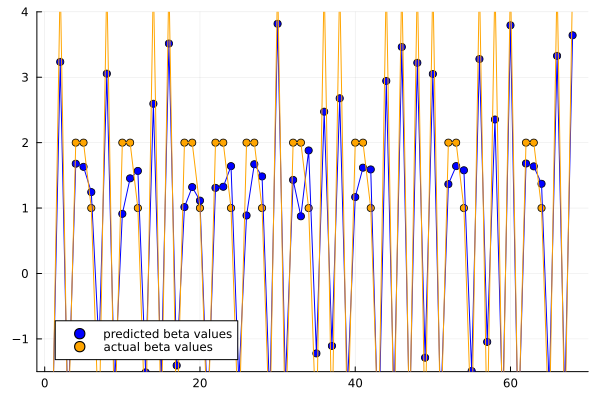

In [16]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-1.5, 4)